# Split Learning and SplitGuard detection proposed in paper <SplitGuard: Detecting and Mitigating Training-Hijacking Attacks in Split Learning>

## Initialization and model defination

In [3]:
import os
import secretflow as sf
import matplotlib.pyplot as plt
sf.shutdown()
sf.init(['alice', 'bob'], address='local',num_cpus=4,num_gpus=1)
alice, bob = sf.PYU('alice'), sf.PYU('bob')
parties=[alice,bob]
import torch
from torch import nn as nn
from torch.nn import functional as F

from secretflow.ml.nn.utils import BaseModule
# The model structure is different from the original paper, thus there is defference in the hyper-parameters and results.
class ConvNetBase(BaseModule):
    """Small ConvNet basenet for cifar10."""

    def __init__(self):
        super(ConvNetBase, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                padding=1
            ),
            nn.ReLU()
        )
        self.pool1=nn.MaxPool2d(2,2)
        self.conv2=nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                padding=1
            ),
            nn.ReLU()
        )
        self.pool2=nn.MaxPool2d(2,2)
        self.conv3=nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                padding=1
            ),
            nn.ReLU()
        )
        self.pool3=nn.MaxPool2d(2,2)
        # fully connected layer, output 10 classes
        self.out = nn.Linear(4*4*64, 500)

    def forward(self, x):
        x = self.conv1(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.pool2(x)
        x=self.conv3(x)
        x=self.pool3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

    def output_num(self):
        return 1


class ConvNetFuse(BaseModule):
    """Small ConvNet basenet for MNIST."""

    def __init__(self):
        super(ConvNetFuse, self).__init__()
        self.fc1 = nn.Linear(500 * 2, 500)
        self.fc1act=nn.ReLU()
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        x = torch.cat(x, dim=1)
        x = x.view(-1, 1000)
        x = self.fc1(x)
        x=self.fc1act(x)
        x = self.fc2(x)
        return x

2023-10-21 00:27:14,242	INFO worker.py:1538 -- Started a local Ray instance.


## Use label replace to compute the SG score(replace 7 batches out of 79 batches) 

In [4]:

import math
import os
import tempfile

import numpy as np
from torch import nn, optim
from torchmetrics import Accuracy, Precision, AUROC
from secretflow.device import reveal
from slmodel_splitguard import SLModel_SG

# from secretflow.ml.nn import SLModel
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn.utils import TorchModel
from secretflow.security.privacy import DPStrategy
from secretflow.security.privacy.mechanism.torch import GaussianEmbeddingDP
from secretflow.security.privacy.mechanism.label_dp import LabelDP
from secretflow.utils.compressor import TopkSparse
from secretflow.utils.simulation.data.ndarray import create_ndarray
from secretflow.data.ndarray import FedNdarray, PartitionWay
from secretflow.device.device.pyu import PYU
from typing import Dict, List, Tuple, Union
import random
from collections import namedtuple
from secretflow.utils.simulation.datasets import get_dataset
import torchvision
import pickle
_temp_dir = tempfile.mkdtemp()
NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)
fake_batch=[]
def load_cifar10(
    parts_train: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
    parts_test: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
    normalized_x: bool = True,
    categorical_y: bool = False,
    is_torch: bool = False,
    batch_size:int=32,
    N:int=20,
    P_F:float=0.1,
    B_F:int=32,
) -> Tuple[Tuple[FedNdarray, FedNdarray], Tuple[FedNdarray, FedNdarray]]:
    x_train,y_train,x_test,y_test=[],[],[],[]
    base_folder = "cifar-10-batches-py"
    train_list = [
        ["data_batch_1", "c99cafc152244af753f735de768cd75f"],
        ["data_batch_2", "d4bba439e000b95fd0a9bffe97cbabec"],
        ["data_batch_3", "54ebc095f3ab1f0389bbae665268c751"],
        ["data_batch_4", "634d18415352ddfa80567beed471001a"],
        ["data_batch_5", "482c414d41f54cd18b22e5b47cb7c3cb"],
    ]
    test_list = [
        ["test_batch", "40351d587109b95175f43aff81a1287e"],
    ]
    cifar10_train=torchvision.datasets.CIFAR10(root='./data',train=True,download=True)
    cifar10_test=torchvision.datasets.CIFAR10(root='./data',train=False,download=True)
    for file_name, checksum in train_list:
        file_path = os.path.join('./data', base_folder, file_name)
        with open(file_path, "rb") as f:
            entry = pickle.load(f, encoding="latin1")
            x_train.append(entry["data"])
            if "labels" in entry:
                y_train.extend(entry["labels"])
            else:
                y_train.extend(entry["fine_labels"])

    x_train = np.vstack(x_train).reshape(-1, 3, 32, 32)
    # x_train = x_train.transpose((0, 1, 3, 2))  # convert to HWC
    y_train=np.array(y_train)
    for file_name, checksum in test_list:
        file_path = os.path.join('./data', base_folder, file_name)
        with open(file_path, "rb") as f:
            entry = pickle.load(f, encoding="latin1")
            x_test.append(entry["data"])
            if "labels" in entry:
                y_test.extend(entry["labels"])
            else:
                y_test.extend(entry["fine_labels"])

    x_test = np.vstack(x_test).reshape(-1, 3, 32, 32)
    # x_test = x_test.transpose((0, 2, 3, 1))  # convert to HWC

    y_test=np.array(y_test)
    
    # Set fake batches as paper.
    batch_num=len(y_train)//batch_size
    for i in range(batch_num):
        send_fakes=i>N and random.random()<=P_F
        if send_fakes and B_F>0:
            index=random.sample(range(batch_size),B_F)
            index=[item+batch_size*i for item in index]
            for idx in index:
                y_train[idx]=(y_train[idx]+ random.randint(1,8)) % 10
            fake_batch.append(i)
    if normalized_x:
        x_train, x_test = x_train / 255, x_test / 255

    if categorical_y:
        from sklearn.preprocessing import OneHotEncoder

        encoder = OneHotEncoder(sparse=False)
        y_train = encoder.fit_transform(y_train.reshape(-1, 1))
        y_test = encoder.fit_transform(y_test.reshape(-1, 1))
        
    return (
        (
            create_ndarray(x_train, parts=parts_train, axis=0),
            create_ndarray(y_train, parts=parts_train, axis=0),
        ),
        (
            create_ndarray(x_test, parts=parts_test, axis=0),
            create_ndarray(y_test, parts=parts_test, axis=0),
        ),
    )

def create_dataset_builder(
    batch_size=32,
):
    def dataset_builder(x):
        import pandas as pd
        import torch
        import torch.utils.data as torch_data

        x = [t.values if isinstance(t, pd.DataFrame) else t for t in x]
        x_copy = [torch.tensor(t.copy()) for t in x]
        data_set = torch_data.TensorDataset(*x_copy)
        dataloader = torch_data.DataLoader(
            dataset=data_set,
            batch_size=batch_size,
        )
        return dataloader

    return dataset_builder


def torch_model_with_cifar10(
    devices,
    base_model_dict,
    device_y,
    model_fuse,
    data_train,
    label_train,
    data_test,
    label_test,
    batch_size,
    N,
    alpha,
    beta,
    strategy='split_nn',
    backend='torch',
    **kwargs
):
    # kwargs parsing
    dp_strategy_dict = kwargs.get('dp_strategy_dict', None)
    compressor = kwargs.get('compressor', None)
    dataset_builder = kwargs.get('dataset_builder', None)

    base_local_steps = kwargs.get('base_local_steps', 1)
    fuse_local_steps = kwargs.get('fuse_local_steps', 1)
    bound_param = kwargs.get('bound_param', 0.0)

    loss_thres = kwargs.get('loss_thres', 0.01)
    split_steps = kwargs.get('split_steps', 1)
    max_fuse_local_steps = kwargs.get('max_fuse_local_steps', 10)
    
    # Define model class using modified class SLModel_SG 
    sl_model = SLModel_SG(
        base_model_dict=base_model_dict,
        device_y=device_y,
        model_fuse=model_fuse,
        dp_strategy_dict=dp_strategy_dict,
        compressor=compressor,
        simulation=True,
        random_seed=1234,
        backend=backend,
        strategy=strategy,
        N=N,
        alpha=alpha,
        beta=beta,
        fake_batch=fake_batch,
        base_local_steps=base_local_steps,
        fuse_local_steps=fuse_local_steps,
        bound_param=bound_param,
        loss_thres=loss_thres,
        split_steps=split_steps,
        max_fuse_local_steps=max_fuse_local_steps,
    )
    # The fit() function is modified.
    history = sl_model.fit(
        data_train,
        label_train,
        validation_data=(data_test, label_test),
        epochs=5,
        batch_size=batch_size,
        shuffle=False,
        random_seed=1234,
        dataset_builder=dataset_builder,
    )
    global_metric = sl_model.evaluate(
        data_test,
        label_test,
        batch_size=batch_size,
        random_seed=1234,
        dataset_builder=dataset_builder,
    )

    # test history
    print(global_metric)
    print(history)
    assert math.isclose(
        global_metric['MulticlassAccuracy'],
        history['val_MulticlassAccuracy'][-1],
        rel_tol=0.01,
    )
    return sl_model.results,history['val_MulticlassAccuracy'][-1]


In [5]:
def test_torch_model(devices,batch_size,N,P_F,B_F,alpha,beta):
    alice = devices[0]
    bob = devices[1]
    num_samples_train = 50000
    num_samples_test=10000
    (data_train, label_train), (data_test, label_test) = load_cifar10(
        parts_train={
            alice: (0, num_samples_train),
            bob: (0, num_samples_train),
        },
        parts_test={
            alice: (0, num_samples_test),
            bob: (0, num_samples_test),
        },
        normalized_x=True,
        categorical_y=True,
        is_torch=True,
        batch_size=batch_size,
        N=N,
        P_F=P_F,
        B_F=B_F,
    )
    data_train = data_train.astype(np.float32)
    label_train = label_train.astype(np.float32)
    data_test = data_test.astype(np.float32)
    label_test = label_test.astype(np.float32)
    
    loss_fn = nn.CrossEntropyLoss
    optim_fn = optim_wrapper(optim.Adam, lr=1e-3)
    base_model = TorchModel(
        model_fn=ConvNetBase,
        loss_fn=loss_fn,
        optim_fn=optim_fn,
        metrics=[
            metric_wrapper(
                Accuracy, task="multiclass", num_classes=10, average='micro'
            ),
            metric_wrapper(
                Precision, task="multiclass", num_classes=10, average='micro'
            ),
            metric_wrapper(AUROC, task="multiclass", num_classes=10),
        ],
    )

    fuse_model = TorchModel(
        model_fn=ConvNetFuse,
        loss_fn=loss_fn,
        optim_fn=optim_fn,
        metrics=[
            metric_wrapper(
                Accuracy, task="multiclass", num_classes=10, average='micro'
            ),
            metric_wrapper(
                Precision, task="multiclass", num_classes=10, average='micro'
            ),
            metric_wrapper(AUROC, task="multiclass", num_classes=10),
        ],
    )
    base_model_dict = {
        alice: base_model,
        bob: base_model,
    }

    # test dataset builder
    print("test Dataset builder")
    dataset_builder_dict = {
        alice: create_dataset_builder(
            batch_size=batch_size,
        ),
        bob: create_dataset_builder(
            batch_size=batch_size,
        ),
    }
    result,acc=torch_model_with_cifar10(
        devices=devices,
        base_model_dict=base_model_dict,
        device_y=bob,
        model_fuse=fuse_model,
        data_train=data_train,
        label_train=label_train,
        data_test=data_test,
        label_test=label_test,
        N=N,
        alpha=alpha,
        beta=beta,
        batch_size=batch_size,
        strategy='split_nn',
        backend="torch",
        dataset_builder=dataset_builder_dict,
    )
    return result,acc


Files already downloaded and verified
Files already downloaded and verified


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.


test Dataset builder


INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7faa70664d30>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7faa70664af0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7faa70664f10>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7faa707dc1f0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7faa707dc280>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7faa707dc2b0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7faa707dc6d0>, PYURuntime(bob): <s

{'val_loss': array(1.3940136, dtype=float32), 'MulticlassAccuracy': tensor(0.5700), 'MulticlassPrecision': tensor(0.5700), 'MulticlassAUROC': tensor(0.9152)}
{'train_loss': [array(2.2439604, dtype=float32), array(1.8963958, dtype=float32), array(2.012567, dtype=float32), array(1.7781417, dtype=float32), array(1.5661255, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.3778), tensor(0.4632), tensor(0.4926), tensor(0.5153), tensor(0.5296)], 'train_MulticlassPrecision': [tensor(0.3778), tensor(0.4632), tensor(0.4926), tensor(0.5153), tensor(0.5296)], 'train_MulticlassAUROC': [tensor(0.8051), tensor(0.8466), tensor(0.8569), tensor(0.8641), tensor(0.8689)], 'val_val_loss': [array(1.5063777, dtype=float32), array(1.3617268, dtype=float32), array(1.4633842, dtype=float32), array(1.3862243, dtype=float32), array(1.3940136, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.4745), tensor(0.5324), tensor(0.5449), tensor(0.5703), tensor(0.5700)], 'val_MulticlassPrecision': [tensor(0.4745)

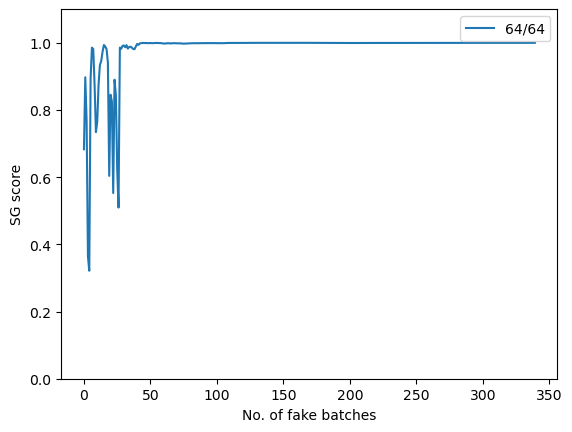

In [6]:

batch_size=64
N=20
P_F=0.1
B_F=64
alpha=5
beta=2
fake_batch=[]
scores0,acc0=test_torch_model(parties,batch_size,N,P_F,B_F,alpha,beta)

plt.plot(scores0, label="64/64")

plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

Files already downloaded and verified
Files already downloaded and verified


(raylet) Spilled 2808 MiB, 7997 objects, write throughput 512 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 4226 MiB, 8002 objects, write throughput 361 MiB/s.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.


test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7faa70559310>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7faa703f45e0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7faa70435a00>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7faa70469a60>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7faa707066d0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7faa705c9c70>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNd

{'val_loss': array(1.1140015, dtype=float32), 'MulticlassAccuracy': tensor(0.6481), 'MulticlassPrecision': tensor(0.6481), 'MulticlassAUROC': tensor(0.9422)}
{'train_loss': [array(1.8831778, dtype=float32), array(1.690773, dtype=float32), array(1.3852226, dtype=float32), array(1.2716315, dtype=float32), array(1.2391372, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.4152), tensor(0.5444), tensor(0.5985), tensor(0.6274), tensor(0.6453)], 'train_MulticlassPrecision': [tensor(0.4152), tensor(0.5444), tensor(0.5985), tensor(0.6274), tensor(0.6453)], 'train_MulticlassAUROC': [tensor(0.8333), tensor(0.8895), tensor(0.9079), tensor(0.9163), tensor(0.9216)], 'val_val_loss': [array(1.2846969, dtype=float32), array(1.1242154, dtype=float32), array(1.068285, dtype=float32), array(1.0061154, dtype=float32), array(1.1140015, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.5258), tensor(0.6036), tensor(0.6253), tensor(0.6510), tensor(0.6481)], 'val_MulticlassPrecision': [tensor(0.5258),

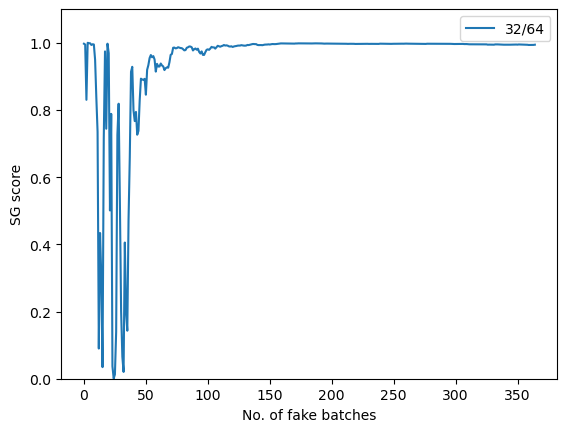

In [7]:
B_F=32
fake_batch=[]
scores1,acc1=test_torch_model(parties,batch_size,N,P_F,B_F,alpha,beta)
plt.plot(scores1, label="32/64")
plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

Files already downloaded and verified
Files already downloaded and verified


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.


test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fa9d465ebb0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fa9d4623dc0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fa9d469b400>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fa9d462a220>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fa9d462a100>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fa9d462a160>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNd

{'val_loss': array(1.1715099, dtype=float32), 'MulticlassAccuracy': tensor(0.6847), 'MulticlassPrecision': tensor(0.6847), 'MulticlassAUROC': tensor(0.9485)}
{'train_loss': [array(1.8164961, dtype=float32), array(1.1713381, dtype=float32), array(0.8882036, dtype=float32), array(0.8248175, dtype=float32), array(0.4606867, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.4352), tensor(0.5864), tensor(0.6403), tensor(0.6736), tensor(0.6987)], 'train_MulticlassPrecision': [tensor(0.4352), tensor(0.5864), tensor(0.6403), tensor(0.6736), tensor(0.6987)], 'train_MulticlassAUROC': [tensor(0.8487), tensor(0.9115), tensor(0.9293), tensor(0.9393), tensor(0.9460)], 'val_val_loss': [array(1.4451354, dtype=float32), array(1.3814845, dtype=float32), array(1.1985006, dtype=float32), array(1.249918, dtype=float32), array(1.1715099, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.5566), tensor(0.6344), tensor(0.6559), tensor(0.6711), tensor(0.6847)], 'val_MulticlassPrecision': [tensor(0.5566)

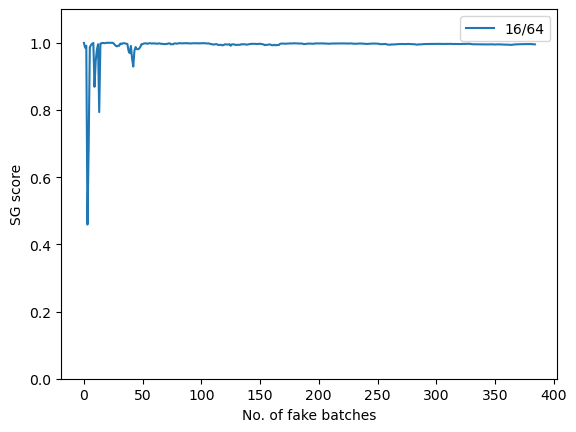

In [8]:
B_F=16
fake_batch=[]
scores2,acc2=test_torch_model(parties,batch_size,N,P_F,B_F,alpha,beta)
plt.plot(scores2, label="16/64")
plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

Files already downloaded and verified
Files already downloaded and verified


(raylet) Spilled 33580 MiB, 34129 objects, write throughput 519 MiB/s.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.


test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fa9d445e280>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fa9d47ffe80>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fa9d448d340>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fa9d464c3d0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fa9d4524550>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fa9d4486a00>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNd

{'val_loss': array(1.1083549, dtype=float32), 'MulticlassAccuracy': tensor(0.6770), 'MulticlassPrecision': tensor(0.6770), 'MulticlassAUROC': tensor(0.9498)}
{'train_loss': [array(1.8717606, dtype=float32), array(1.3788718, dtype=float32), array(0.92648077, dtype=float32), array(0.7617243, dtype=float32), array(0.47384977, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.4511), tensor(0.6138), tensor(0.6772), tensor(0.7169), tensor(0.7434)], 'train_MulticlassPrecision': [tensor(0.4511), tensor(0.6138), tensor(0.6772), tensor(0.7169), tensor(0.7434)], 'train_MulticlassAUROC': [tensor(0.8643), tensor(0.9290), tensor(0.9496), tensor(0.9600), tensor(0.9670)], 'val_val_loss': [array(1.4620597, dtype=float32), array(1.2433364, dtype=float32), array(1.4422891, dtype=float32), array(1.2385433, dtype=float32), array(1.1083549, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.5489), tensor(0.6447), tensor(0.6575), tensor(0.6706), tensor(0.6770)], 'val_MulticlassPrecision': [tensor(0.54

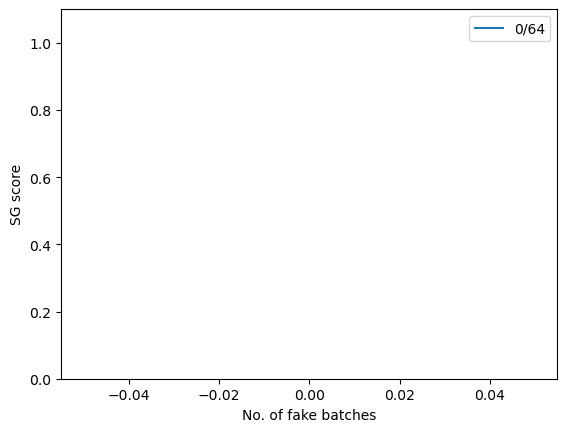

In [9]:
B_F=0
fake_batch=[]
scores3,acc3=test_torch_model(parties,batch_size,N,P_F,B_F,alpha,beta)
plt.plot(scores3, label="0/64")
plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

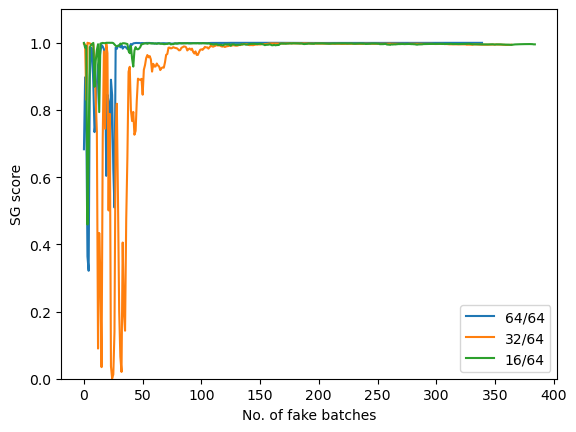

In [10]:
plt.plot(scores0, label="64/64")
plt.plot(scores1, label="32/64")
plt.plot(scores2, label="16/64")

plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

In [11]:
print("Test classification accuracy values for the cifar10 dataset for different B_F values with SplitGuard, with P_F=0.1")
print("BF=64, ACC=",acc0)
print("BF=32, ACC=",acc1)
print("BF=16, ACC=",acc2)
print("BF=0, ACC=",acc3)

Test classification accuracy values for the cifar10 dataset for different B_F values with SplitGuard, with P_F=0.1
BF=64, ACC= tensor(0.5700)
BF=32, ACC= tensor(0.6481)
BF=16, ACC= tensor(0.6847)
BF=0, ACC= tensor(0.6770)
